In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/106_cyt01.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/094_cyt02.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/001_cyt08.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/019_nuc09.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/045_nuc02.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/096_nuc08.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/042_nuc01.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/034_nuc05.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/041_nuc05.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/096_nuc07.dat
/kaggle/input/cervical-cancer-largest-dataset-sipa

In [2]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, transform
import pandas as pd
import pickle
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Update this path to your dataset location
dataset_path = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed"

# List of cell classes in the dataset
classes = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

# Dictionary to store paths for each class
class_paths = {}

# Find all image paths for each class
for cell_class in classes:
    class_folder = f"im_{cell_class}"
    inner_folder_path = os.path.join(dataset_path, class_folder, class_folder, "CROPPED")
    image_paths = glob.glob(os.path.join(inner_folder_path, "*.bmp"))
    class_paths[cell_class] = image_paths

# Print number of images per class
for cell_class, paths in class_paths.items():
    print(f"{cell_class}: {len(paths)} images")

Dyskeratotic: 813 images
Koilocytotic: 825 images
Metaplastic: 793 images
Parabasal: 787 images
Superficial-Intermediate: 831 images


In [5]:
def read_contour_file(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        contour_points = []
        for line in lines:
            if line.strip():  # Skip empty lines
                try:
                    x, y = map(float, line.strip().split(','))
                except ValueError:
                    x, y = map(float, line.strip().split())
                contour_points.append([int(x), int(y)])
        return np.array(contour_points, dtype=np.int32)
    except FileNotFoundError:
        print(f"Warning: File {file_path} not found.")
        return None

In [6]:
# Create directories for preprocessed data
output_dir = "preprocessed_data"
os.makedirs(output_dir, exist_ok=True)

images_dir = os.path.join(output_dir, "images")
cytoplasm_masks_dir = os.path.join(output_dir, "cytoplasm_masks")
nucleus_masks_dir = os.path.join(output_dir, "nucleus_masks")

os.makedirs(images_dir, exist_ok=True)
os.makedirs(cytoplasm_masks_dir, exist_ok=True)
os.makedirs(nucleus_masks_dir, exist_ok=True)

def resize_with_padding(image, target_size):
    h, w = image.shape[:2]
    target_h, target_w = target_size

    # Calculate scaling factor to maintain aspect ratio
    scale = min(target_w/w, target_h/h)
    new_w, new_h = int(w * scale), int(h * scale)

    # Resize image
    resized = cv2.resize(image, (new_w, new_h))

    # Create padding
    if len(image.shape) == 3:
        pad_color = [0, 0, 0]
        padded = np.zeros((target_h, target_w, 3), dtype=np.uint8)
    else:
        pad_color = 0
        padded = np.zeros((target_h, target_w), dtype=np.uint8)

    # Calculate padding
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2

    # Place the resized image in the center
    padded[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

    return padded

# Metadata to store information about processed images
metadata = []

# Process all images
for cell_class, image_paths in class_paths.items():
    print(f"Processing {cell_class} class...")
    for img_path in image_paths:
        img_name = os.path.basename(img_path).split('.')[0]
        cyto_dat_path = os.path.join(os.path.dirname(img_path), f"{img_name}_cyt.dat")
        nucleus_dat_path = os.path.join(os.path.dirname(img_path), f"{img_name}_nuc.dat")

        # Load the image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not load image {img_path}. Skipping.")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read contour data
        cytoplasm_contour = read_contour_file(cyto_dat_path)
        nucleus_contour = read_contour_file(nucleus_dat_path)

        # Create binary masks
        height, width = image.shape[:2]
        cytoplasm_mask = np.zeros((height, width), dtype=np.uint8)
        nucleus_mask = np.zeros((height, width), dtype=np.uint8)

        if cytoplasm_contour is not None:
            cv2.drawContours(cytoplasm_mask, [cytoplasm_contour], 0, 255, -1)
        if nucleus_contour is not None:
            cv2.drawContours(nucleus_mask, [nucleus_contour], 0, 255, -1)

        # Resize with padding
        target_size = (48, 62)  # height, width
        resized_image = resize_with_padding(image, target_size)
        cytoplasm_mask_resized = resize_with_padding(cytoplasm_mask, target_size)
        nucleus_mask_resized = resize_with_padding(nucleus_mask, target_size)

        # Binarize masks
        _, cytoplasm_mask_resized = cv2.threshold(cytoplasm_mask_resized, 127, 255, cv2.THRESH_BINARY)
        _, nucleus_mask_resized = cv2.threshold(nucleus_mask_resized, 127, 255, cv2.THRESH_BINARY)

        # Save preprocessed data
        output_image_path = os.path.join(images_dir, f"{cell_class}_{img_name}.png")
        output_cyto_mask_path = os.path.join(cytoplasm_masks_dir, f"{cell_class}_{img_name}_cytoplasm.png")
        output_nucleus_mask_path = os.path.join(nucleus_masks_dir, f"{cell_class}_{img_name}_nucleus.png")

        cv2.imwrite(output_image_path, cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))
        cv2.imwrite(output_cyto_mask_path, cytoplasm_mask_resized)
        cv2.imwrite(output_nucleus_mask_path, nucleus_mask_resized)

        # Add metadata
        metadata.append({
            'class': cell_class,
            'original_image_path': img_path,
            'preprocessed_image_path': output_image_path,
            'cytoplasm_mask_path': output_cyto_mask_path,
            'nucleus_mask_path': output_nucleus_mask_path,
        })

# Save metadata
metadata_df = pd.DataFrame(metadata)
metadata_df.to_csv(os.path.join(output_dir, "metadata.csv"), index=False)
print(f"Preprocessing completed. Total processed images: {len(metadata_df)}")

Processing Dyskeratotic class...
Processing Koilocytotic class...
Processing Metaplastic class...
Processing Parabasal class...
Processing Superficial-Intermediate class...
Preprocessing completed. Total processed images: 4049


Class distribution:
class
Superficial-Intermediate    831
Koilocytotic                825
Dyskeratotic                813
Metaplastic                 793
Parabasal                   787
Name: count, dtype: int64


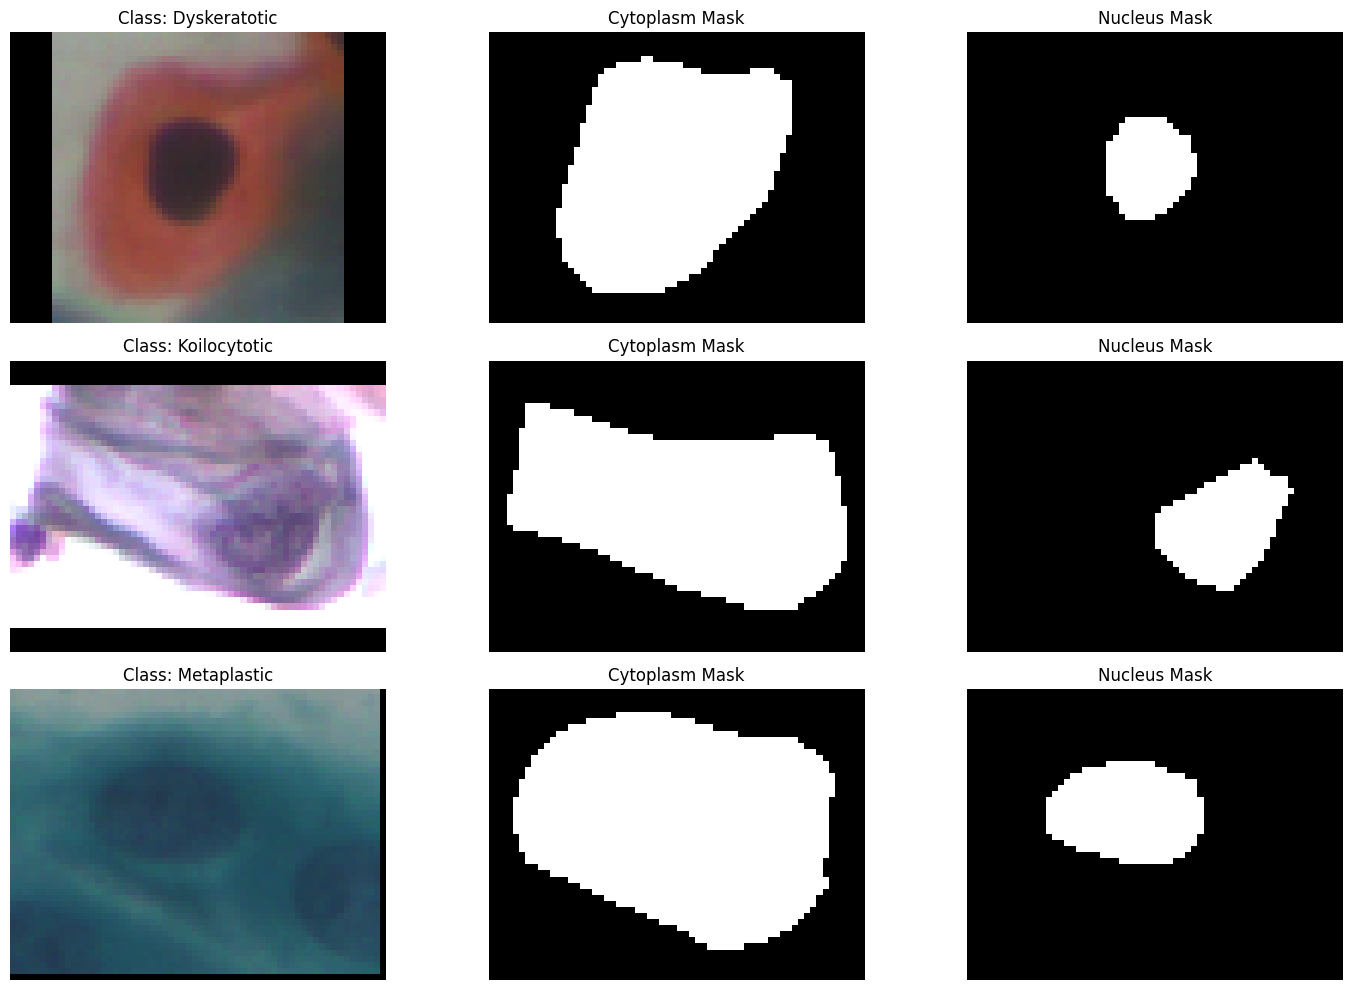

In [7]:
# Load metadata
metadata_df = pd.read_csv(os.path.join(output_dir, "metadata.csv"))

# Display class distribution
class_distribution = metadata_df['class'].value_counts()
print("Class distribution:")
print(class_distribution)

# Display a few example preprocessed images and masks
sample_rows = metadata_df.groupby('class').first().reset_index()

plt.figure(figsize=(15, 10))
for i, (_, row) in enumerate(sample_rows.iterrows()):
    if i >= 3:  # Show only 3 examples
        break
    img = cv2.imread(row['preprocessed_image_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cyto_mask = cv2.imread(row['cytoplasm_mask_path'], cv2.IMREAD_GRAYSCALE)
    nucleus_mask = cv2.imread(row['nucleus_mask_path'], cv2.IMREAD_GRAYSCALE)

    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(img)
    plt.title(f"Class: {row['class']}")
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(cyto_mask, cmap='gray')
    plt.title("Cytoplasm Mask")
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(nucleus_mask, cmap='gray')
    plt.title("Nucleus Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def compute_circularity(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return 0
    contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if area == 0:
        return 0
    return (perimeter ** 2) / (4 * np.pi * area)

def compute_mean_color(image, mask):
    mean_color = cv2.mean(image, mask=mask)
    return mean_color[:3]  # Return only the RGB values

def compute_hog(image):
    image_resized = cv2.resize(image, (48, 48))  

    # HOG window size and parameters
    win_size = (48, 48)  # Define the window size
    block_size = (16, 16)  # Block size (should divide window size evenly)
    block_stride = (8, 8)  # Block stride (must be compatible with the window and block size)
    cell_size = (8, 8)  # Cell size (should also divide block size evenly)
    nbins = 9  # Number of bins for the histogram

    hog = cv2.HOGDescriptor(_winSize=win_size, _blockSize=block_size, _blockStride=block_stride,
                            _cellSize=cell_size, _nbins=nbins)
    
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

    hog_features = hog.compute(gray)

    # If the result is empty, handle the issue
    if hog_features is None or hog_features.size == 0:
        print(f"HOG computation failed for image with shape {gray.shape}. Returning empty feature vector.")
        return np.zeros(3780)  # Return a zero vector in case of failure

    return hog_features.flatten()

def compute_sift(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None:
        return np.zeros(128)  # Return a zero vector if no descriptors found
    # Use the mean of all SIFT descriptors to get a fixed-length feature vector
    return np.mean(descriptors, axis=0)
    
def extract_features(metadata_df):
    feature_list = []

    for _, row in metadata_df.iterrows():
        img_path = row['preprocessed_image_path']
        nucleus_mask_path = row['nucleus_mask_path']
        cyto_mask_path = row['cytoplasm_mask_path']

        
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        nucleus_mask = cv2.imread(nucleus_mask_path, cv2.IMREAD_GRAYSCALE)
        cyto_mask = cv2.imread(cyto_mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or nucleus_mask is None or cyto_mask is None:
            print(f"Skipping {img_path} due to load error.")
            continue

        # mean intensity in cytoplasm and nucleus
        cyto_intensity = cv2.mean(image, mask=cyto_mask)[:3]
        nucleus_intensity = cv2.mean(image, mask=nucleus_mask)[:3]
        
        # HOG features
        hog_features = compute_hog(image)
        # Circularity for both cytoplasm and nucleus
        cyto_circularity = compute_circularity(cyto_mask)
        nucleus_circularity = compute_circularity(nucleus_mask)
        
        # SIFT features
        sift_features = compute_sift(image)

        feature_dict = {
            'path': img_path,
            'class': row['class'],
            'cytoplasm_mean_r': cyto_intensity[2],
            'cytoplasm_mean_g': cyto_intensity[1],
            'cytoplasm_mean_b': cyto_intensity[0],
            'nucleus_mean_r': nucleus_intensity[2],
            'nucleus_mean_g': nucleus_intensity[1],
            'nucleus_mean_b': nucleus_intensity[0],
            'cyto_circ': cyto_circularity,
            'nucleus_circ': nucleus_circularity
        }

        # Add HOG features as separate columns
        for i in range(len(hog_features)):
            feature_dict[f"hog_{i+1}"] = hog_features[i]

        # Add SIFT features as separate columns
        for i in range(len(sift_features)):
            feature_dict[f"sift_{i+1}"] = sift_features[i]

        feature_list.append(feature_dict)
    return pd.DataFrame(feature_list)




In [9]:
features_df = extract_features(metadata_df)
# Separate features and labels
class_mapping = {
        "Superficial-Intermediate": "Normal",
        "Parabasal": "Precancerous",
        "Koilocytotic": "Precancerous",
        "Dyskeratotic": "Cancerous",
        "Metaplastic": "Normal"
    }
    
    # Apply the mapping
features_df['class_mapped'] = features_df['class'].map(class_mapping)
features_df.head(20)


,path,class,cytoplasm_mean_r,cytoplasm_mean_g,cytoplasm_mean_b,nucleus_mean_r,nucleus_mean_g,nucleus_mean_b,cyto_circ,nucleus_circ,...,sift_120,sift_121,sift_122,sift_123,sift_124,sift_125,sift_126,sift_127,sift_128,class_mapped
0,preprocessed_data/images/Dyskeratotic_025_01.png,Dyskeratotic,128.497774,71.377560,67.760463,68.577114,44.935323,51.278607,1.273848,1.145887,...,1.000000,0.000000,5.000000,77.000000,11.000000,2.000000,0.000000,0.000000,0.000000,Cancerous
1,preprocessed_data/images/Dyskeratotic_001_01.png,Dyskeratotic,131.646947,73.948473,71.760496,69.858757,44.186441,53.050847,1.353018,1.181123,...,4.000000,1.500000,5.000000,37.500000,5.500000,0.500000,0.000000,0.000000,0.000000,Cancerous
2,preprocessed_data/images/Dyskeratotic_088_03.png,Dyskeratotic,209.311186,113.611438,143.012616,161.927152,74.152318,113.814570,1.143772,1.130049,...,35.000000,8.500000,14.500000,36.000000,79.500000,79.500000,1.500000,0.000000,6.500000,Cancerous
3,preprocessed_data/images/Dyskeratotic_006_04.png,Dyskeratotic,94.658927,65.812650,63.060849,58.580808,41.898990,48.974747,1.337886,1.196075,...,60.000000,19.000000,15.000000,38.000000,1.000000,0.000000,0.000000,3.000000,16.000000,Cancerous
4,preprocessed_data/images/Dyskeratotic_202_01.png,Dyskeratotic,135.038217,80.885350,117.305732,103.912371,69.479381,99.391753,1.310078,1.379397,...,0.000000,0.000000,0.000000,13.000000,23.000000,0.000000,0.000000,0.000000,0.000000,Cancerous
5,preprocessed_data/images/Dyskeratotic_101_07.png,Dyskeratotic,107.301887,51.600343,70.809605,77.770035,40.386760,61.000000,1.541406,1.444169,...,17.750000,23.875000,10.125000,7.250000,36.625000,31.000000,7.750000,6.875000,17.000000,Cancerous
6,preprocessed_data/images/Dyskeratotic_156_02.png,Dyskeratotic,168.692782,67.791373,44.174296,131.100840,52.319328,37.733894,1.303064,1.326290,...,11.375000,3.875000,9.375000,24.125000,23.000000,4.375000,0.375000,2.125000,3.250000,Cancerous
7,preprocessed_data/images/Dyskeratotic_072_07.png,Dyskeratotic,74.988497,52.618865,48.078988,55.289216,39.558824,44.102941,1.198372,1.156317,...,5.666667,0.666667,0.000000,0.000000,0.000000,4.333333,7.666667,3.333333,1.666667,Cancerous
8,preprocessed_data/images/Dyskeratotic_009_09.png,Dyskeratotic,107.987782,73.808271,74.621241,68.587302,46.071429,58.746032,1.603415,1.167106,...,13.142858,15.428572,13.000000,22.571428,14.428572,6.571429,10.571428,9.000000,25.285715,Cancerous
9,preprocessed_data/images/Dyskeratotic_067_16.png,Dyskeratotic,101.887879,54.690909,54.615152,64.273859,37.514523,51.298755,1.394241,1.236831,...,3.000000,0.000000,2.000000,48.000000,18.000000,0.000000,0.000000,0.000000,0.000000,Cancerous


In [10]:
features_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4049 entries, 0 to 4048
Columns: 1039 entries, path to class_mapped
dtypes: float32(900), float64(136), object(3)
memory usage: 18.2+ MB


In [11]:
print(features_df.isna().sum())


path                0
class               0
cytoplasm_mean_r    0
cytoplasm_mean_g    0
cytoplasm_mean_b    0
                   ..
sift_125            0
sift_126            0
sift_127            0
sift_128            0
class_mapped        0
Length: 1039, dtype: int64


In [12]:
X = features_df.drop(columns=['path', 'class', 'class_mapped'])
y = features_df['class_mapped']
# Encode the target class labels
le = LabelEncoder()
y = le.fit_transform(y)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Filter Methods
## SelectKBest (ANOVA F-test)
k_best_selector = SelectKBest(score_func=f_classif, k=20)
X_k_best = k_best_selector.fit_transform(X_scaled, y)
k_best_features = X.columns[k_best_selector.get_support()]
print("\nSelected Features (SelectKBest - ANOVA F-test):")
print(k_best_features)

## Mutual Information
mi_selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_mi_best = mi_selector.fit_transform(X_scaled, y)
mi_best_features = X.columns[mi_selector.get_support()]
print("\nSelected Features (Mutual Information):")
print(mi_best_features)


Selected Features (SelectKBest - ANOVA F-test):
Index(['cytoplasm_mean_g', 'cytoplasm_mean_b', 'nucleus_mean_g',
       'nucleus_mean_b', 'hog_250', 'hog_251', 'hog_275', 'hog_276', 'hog_277',
       'hog_284', 'hog_414', 'sift_3', 'sift_4', 'sift_11', 'sift_36',
       'sift_37', 'sift_69', 'sift_70', 'sift_102', 'sift_111'],
      dtype='object')

Selected Features (Mutual Information):
Index(['cytoplasm_mean_r', 'cytoplasm_mean_g', 'cytoplasm_mean_b',
       'nucleus_mean_r', 'nucleus_mean_g', 'nucleus_mean_b', 'nucleus_circ',
       'hog_258', 'hog_277', 'hog_280', 'hog_461', 'hog_627', 'sift_4',
       'sift_5', 'sift_36', 'sift_70', 'sift_102', 'sift_104', 'sift_110',
       'sift_111'],
      dtype='object')


Model Accuracy with Selected Features: 0.85
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       163
           1       0.86      0.89      0.87       325
           2       0.82      0.82      0.82       322

    accuracy                           0.85       810
   macro avg       0.85      0.84      0.85       810
weighted avg       0.85      0.85      0.85       810



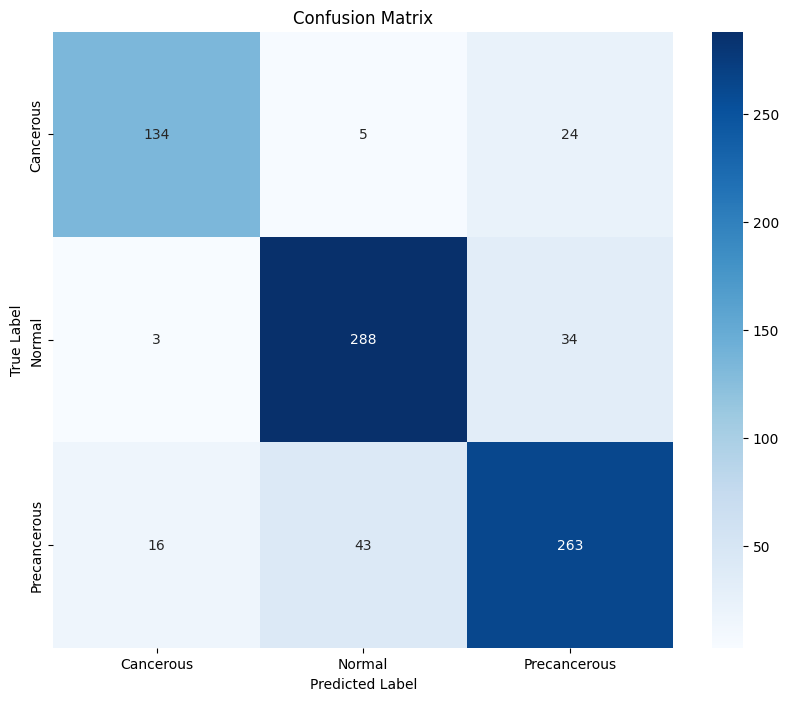

In [13]:
selected_features = [
   'cytoplasm_mean_r', 'cytoplasm_mean_g', 'cytoplasm_mean_b',
       'nucleus_mean_r', 'nucleus_mean_g', 'nucleus_mean_b', 'nucleus_circ','hog_250', 'hog_251'
    , 'hog_275', 'hog_276', 'hog_277',
       'hog_284', 'hog_414', 'sift_3', 'sift_4', 'sift_11', 'sift_36',
       'sift_37', 'sift_69', 'sift_70', 'sift_102', 'sift_111',
       'hog_258', 'hog_280', 'hog_461', 'hog_627',
       'sift_5', 'sift_110'    
]

X_selected = features_df[selected_features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split( X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Evaluate the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy with Selected Features: {accuracy:.2f}")
print(classification_report(y_test, predictions))

# Display the confusion matrix

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix , precision_recall_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
import seaborn as sns

In [26]:
def plot_classification_performance(y_true, y_pred, y_scores=None, classes=None, 
                                   figsize=(16, 6), cmap='Blues', normalize=False):

    if classes is None:
        classes = np.unique(y_true)
    
    n_classes = len(classes)
    
    plt.figure(figsize=figsize)
    
    # Confusion Matrix
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Precision-Recall Curve
    if y_scores is not None:
        plt.subplot(1, 2, 2)
        
        if n_classes == 2:  # Binary classification
            # Handle both 1D and 2D y_scores
            if y_scores.ndim == 1:
                precision, recall, _ = precision_recall_curve(y_true, y_scores)
            else:
                precision, recall, _ = precision_recall_curve(y_true, y_scores[:, 1])
            pr_auc = auc(recall, precision)
            plt.plot(recall, precision, lw=2, 
                     label=f'PR curve (AUC = {pr_auc:.2f})')
        else:  # Multiclass classification
            y_true_bin = label_binarize(y_true, classes=classes)
            
            for i in range(n_classes):
                precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
                pr_auc = auc(recall, precision)
                plt.plot(recall, precision, lw=2, 
                         label=f'Class {classes[i]} (AUC = {pr_auc:.2f})')
        
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='best')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [37]:
# Hyperparameters for Decision Tree, Random Forest, and SVC
from sklearn.model_selection import GridSearchCV, cross_val_score

params_dt = {
    'max_depth': [2, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20, 50],
    'max_leaf_nodes': [10, 30, 50, 100, 200]
}
param_rd = {
    'n_estimators': [100],  
    'max_depth': [None, 10, 20],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],    
    'max_features': ['sqrt', 'log2'], 
    'criterion': ['gini', 'entropy'],
}
svc_params = {
    'kernel' : ('poly', 'rbf'), 
    'C':[0.001, 0.01, 0.1, 0.5, 1, 10]
}

In [17]:
dt_grids = GridSearchCV(DecisionTreeClassifier(), param_grid=params_dt, cv=5).fit(X_train, y_train)
print("Best parameters for Decision Tree: ", dt_grids.best_params_)
print("Best score for Decision Tree: ", dt_grids.best_score_)

Best parameters for Decision Tree:  {'max_depth': 20, 'max_leaf_nodes': 100, 'min_samples_split': 5}
Best score for Decision Tree:  0.7974659873680997


In [18]:
dt_model = DecisionTreeClassifier(max_depth=20, max_leaf_nodes=100, min_samples_split=5)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, max_leaf_nodes=100, min_samples_split=5)

In [19]:
dt_accuracy = accuracy_score(y_test, dt_model.predict(X_test))
print("Decision Tree Accuracy: ", dt_accuracy)

Decision Tree Accuracy:  0.7962962962962963


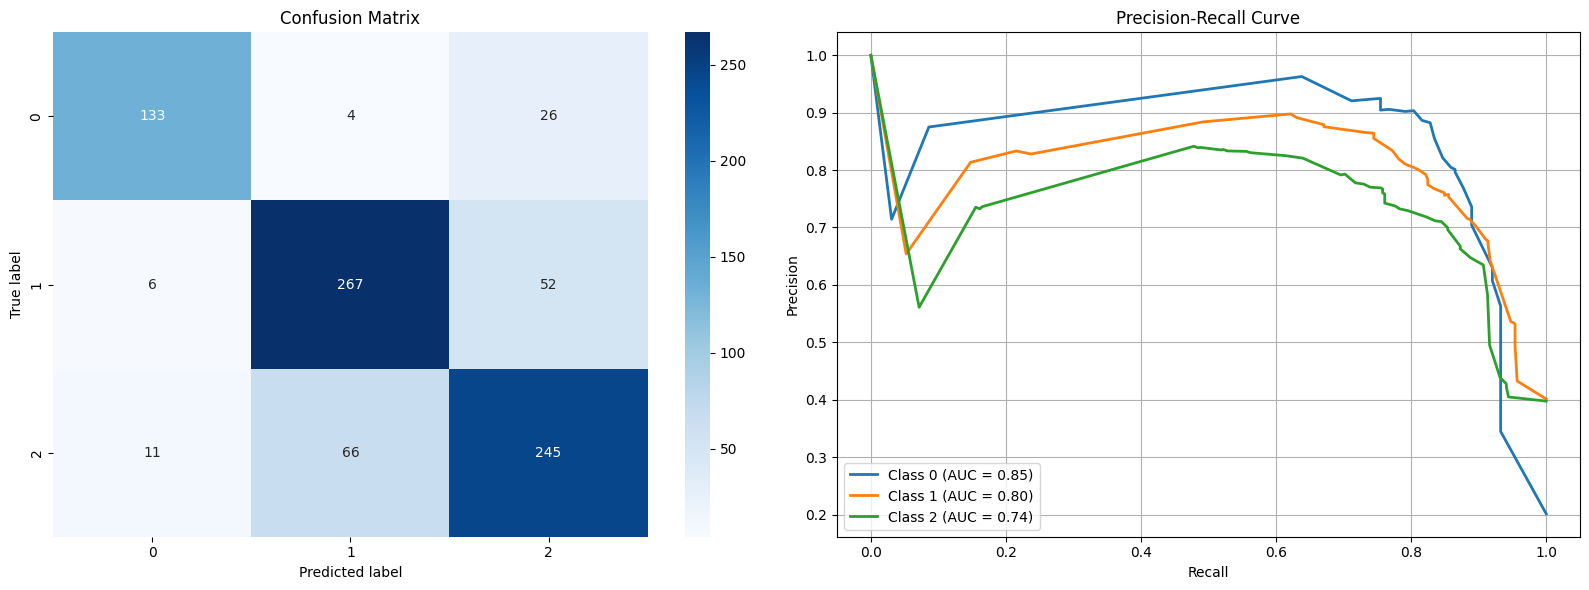

In [28]:
y_scores = dt_model.predict_proba(X_test)  # This is already 1D
plot_classification_performance(y_test, dt_model.predict(X_test), y_scores)

In [29]:
svc_grids = GridSearchCV(SVC(), param_grid=svc_params, cv=5).fit(X_train, y_train)
print("Best parameters for SVC: ", svc_grids.best_params_)
print("Best score for SVC: ", svc_grids.best_score_)

Best parameters for SVC:  {'C': 10, 'kernel': 'rbf'}
Best score for SVC:  0.8548958154445018


In [30]:
svc_model = SVC(kernel='rbf', C=10, probability=True)
svc_model.fit(X_train, y_train)

SVC(C=10, probability=True)

In [31]:
svc_accuracy = accuracy_score(y_test, svc_model.predict(X_test))
print("Support Vector Machine Accuracy: ", svc_accuracy)

Support Vector Machine Accuracy:  0.8567901234567902


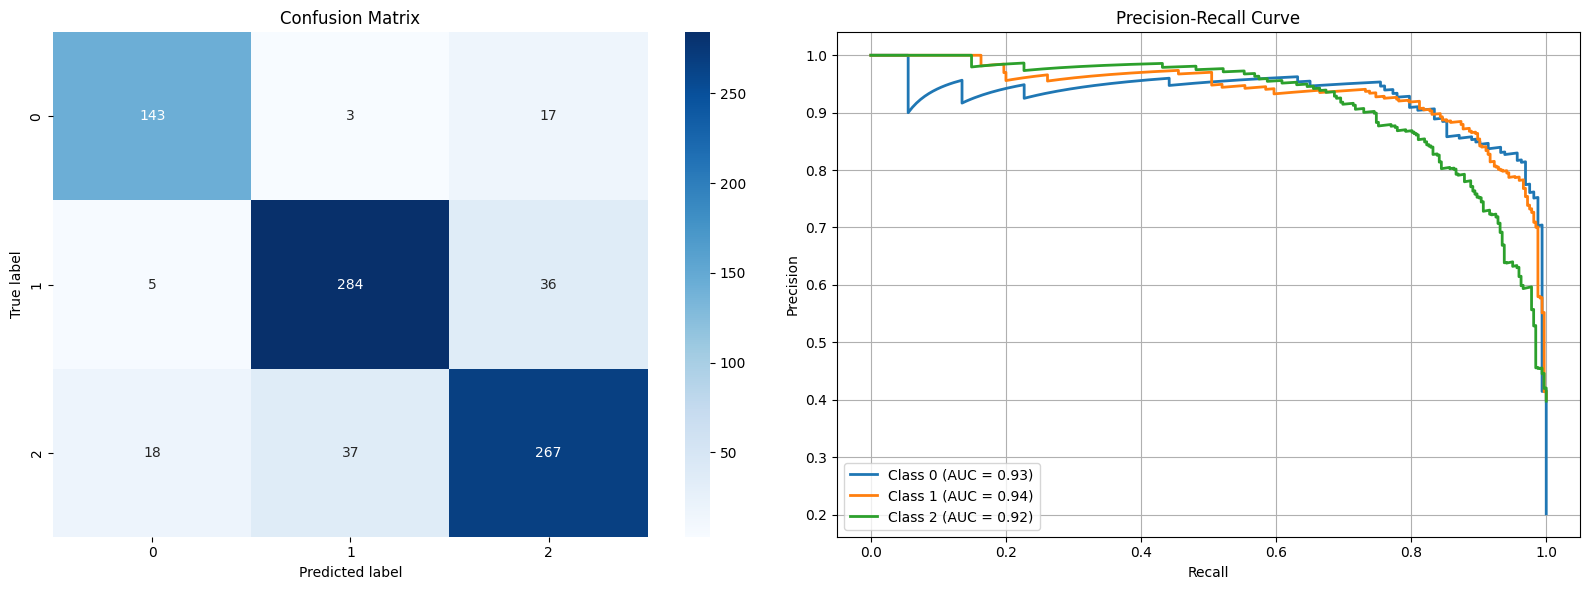

In [34]:
y_scores = svc_model.predict_proba(X_test)  # This is already 1D
plot_classification_performance(y_test, svc_model.predict(X_test), y_scores)

In [38]:
rf_grids = GridSearchCV(RandomForestClassifier(), param_grid=param_rd, cv=5, scoring='accuracy').fit(X_train, y_train)
print("Best parameters for Random Forest: ", rf_grids.best_params_)
print("Best score for Random Forest: ", rf_grids.best_score_)

Best parameters for Random Forest:  {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best score for Random Forest:  0.8536555231171409


In [40]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', criterion='entropy')
rf_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_split=10)

In [43]:
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
print("Random Forest Tree Accuracy: ", rf_accuracy)

Random Forest Tree Accuracy:  0.845679012345679


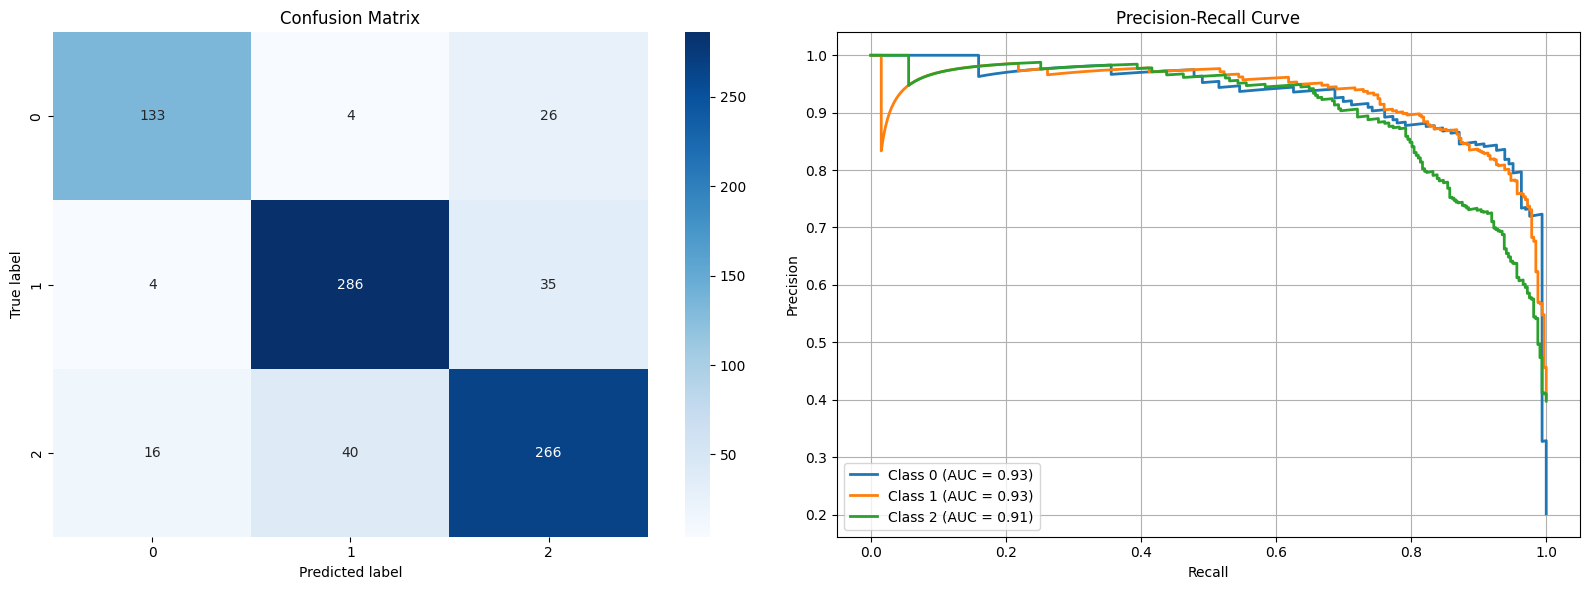

In [45]:
y_scores = rf_model.predict_proba(X_test)  # This is already 1D
plot_classification_performance(y_test, rf_model.predict(X_test), y_scores)

In [49]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_multiclass_roc_curve(y_true, y_scores, model_name, ax, classes=None):
    if classes is None:
        classes = np.unique(y_true)
    
    n_classes = len(classes)
    
    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=classes)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    colors = cycle(['blue', 'red', 'green', 'yellow', 'cyan', 'purple'])
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name} - Multiclass ROC Curve')
    ax.legend(loc='lower right')
    ax.grid(True)

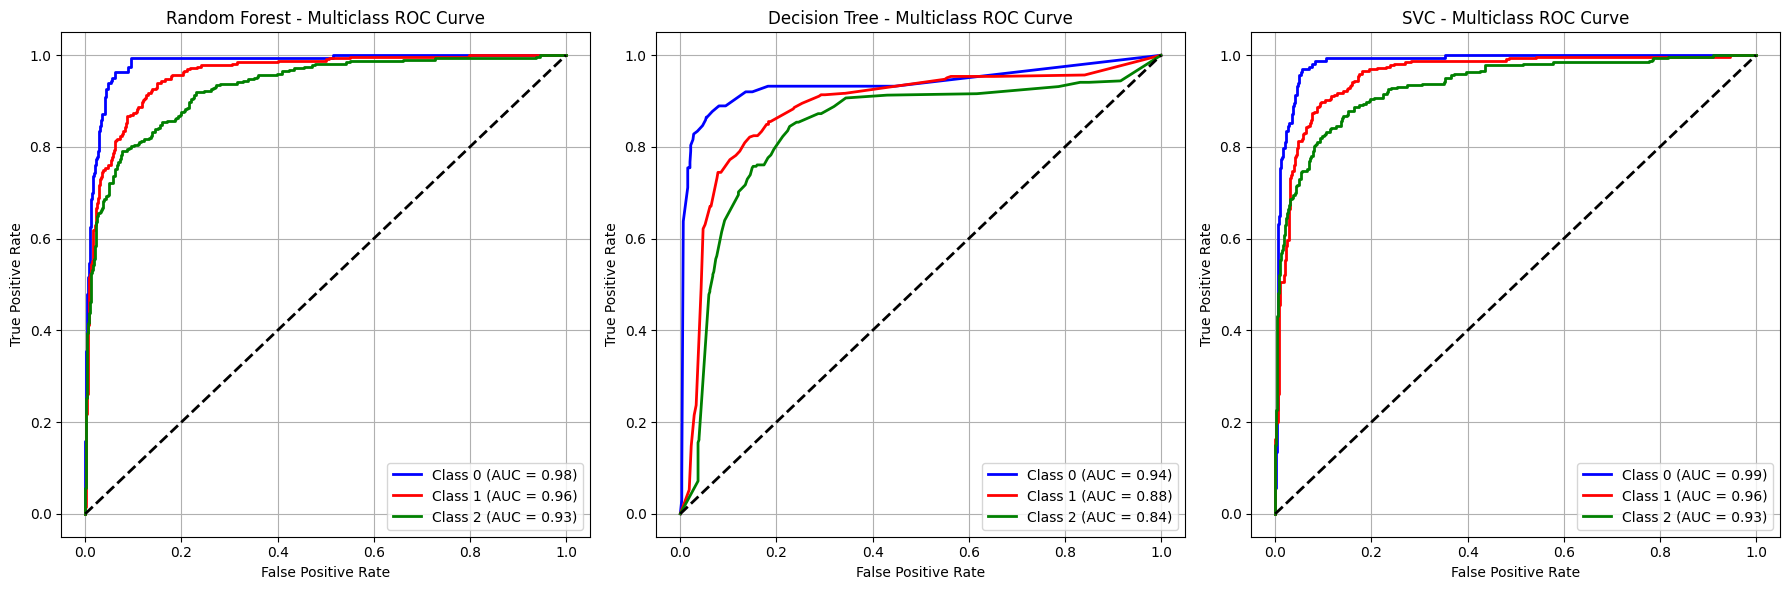

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# # For each model, make sure you're passing the full probability matrix
plot_multiclass_roc_curve(y_test, rf_model.predict_proba(X_test), 'Random Forest', axes[0])
plot_multiclass_roc_curve(y_test, dt_model.predict_proba(X_test), 'Decision Tree', axes[1])
plot_multiclass_roc_curve(y_test, svc_model.predict_proba(X_test), 'SVC', axes[2])

plt.tight_layout()
plt.show()